In [1]:
#Set up the environment
library(reshape2)
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
#Make a vector of all of the ancestry-associated genes
setwd("../data")
ancestry.associated.gene.vector = read.table("lm_ancestry_associated_dependency_pvals.txt", sep = "\t", header = TRUE) %>%
filter(afr_fdr < 0.05 | amr_fdr < 0.05 | eas_fdr < 0.05 | eur_fdr < 0.05 | sas_fdr < 0.05) %>%
pull(gene) %>%
unique()

In [3]:
#Load in the top SNP data
setwd("../data")
top.snp.df = read.table("ancestry_top_snp_df.txt", sep = "\t", header = TRUE)

In [11]:
#Load in the pre-correction chronos scores
setwd("../data")
chronos.22q1 = read.table("22q1_crispr_gene_effect.csv", sep = ",", header = T, check.names = FALSE) %>%
setNames(word(names(.), 1)) %>%
rename("sample" = 1)

In [8]:
#Load in the vcf sample names
setwd("../data")
ccle.vcf.sample.names = read.table("ccle.vcf.sample.names.txt", sep = "\t") %>%
pull(V1)


#Load in the genotyping matrix and format it
setwd("../data")
formatted.ancestry.snp.genotyping.matrix = read.table("ccle.ancestry.snps.vcf.gz", sep = "\t") %>%
select(-V1, -V2, -V4, -V5, -V6, -V7, -V8, -V9) %>%
rename("snp" = V3) %>%
filter(snp %in% top.snp.df$snp)


#Do the final steps of formatting to adjust the genotype call format
final.ancestry.snp.genotyping.matrix = formatted.ancestry.snp.genotyping.matrix %>%
  select(-snp) %>%
  mutate(across(everything(), ~gsub(":..*", "", .))) %>%
  mutate(across(everything(), ~gsub("0\\|0", "0", .))) %>%
  mutate(across(everything(), ~gsub("0\\|1", "1", .))) %>%
  mutate(across(everything(), ~gsub("1\\|0", "1", .))) %>%
  mutate(across(everything(), ~gsub("1\\|1", "2", .))) %>%
  mutate(snp = formatted.ancestry.snp.genotyping.matrix$snp, .before = 1)



#Set the column names
colnames(final.ancestry.snp.genotyping.matrix) = c("snp", ccle.vcf.sample.names)


#Get a list of samples to keep that intersect between the genotyping matrix and the chronos matrix
samples.to.keep = intersect(colnames(final.ancestry.snp.genotyping.matrix), chronos.22q1$sample)


#Filter the dataset so that it only includes the samples that have chronos scores.
final.ancestry.snp.genotyping.matrix = final.ancestry.snp.genotyping.matrix %>%
select(snp, all_of(samples.to.keep))

In [12]:
#Load in the expression data
setwd("../data")
ccle.expression.22q1 = read.table("22q1_expression.csv", sep = ",", header = T, check.names = FALSE) %>%
setNames(word(names(.), 1)) %>%
rename("sample" = 1)


#Filter the expression data so that it only includes ancestry-associated genes and melt it
ancestry.only.expression.22q1 = ccle.expression.22q1 %>%
select(sample, all_of(ancestry.associated.gene.vector)) %>%
melt()

Using sample as id variables



In [13]:
#Load in a dataset with the lineage information for each cell line
setwd('../data')
sample.annotation = read.table('depmap_cell_lineage.csv', sep = ",", header = T) %>%
rename("sample" = 1)

In [14]:
#For each SNP:Gene pair, compute if that SNP is associated with expression of the chronos gene in question
eqtl.association.pval = NULL
eqtl.association.differential.expression = NULL
for(i in 1:nrow(top.snp.df)){
    
    #Store the snp and gene for this iteration of a loop as a new variable
    gene.of.interest = top.snp.df[i, 1]
    snp.of.interest = top.snp.df[i, 2]
    
    
    #Calculate the intersection between all of the samples with expression profiles and all of the genotyped samples
    all.genotyped.samples = final.ancestry.snp.genotyping.matrix %>% melt(id = "snp") %>% pull(variable) %>% unique()
    all.samples.with.expression = ancestry.only.expression.22q1 %>% pull(sample) %>% unique()
    all.intersecting.samples = intersect(all.genotyped.samples, all.samples.with.expression)
    
    
    #Get a vector of cell lines that have the snp or don't have the snp
    lines.with.snp = final.ancestry.snp.genotyping.matrix %>%
    melt(id = "snp") %>%
    filter(variable %in% all_of(all.intersecting.samples)) %>%
    filter(snp %in% all_of(snp.of.interest)) %>%
    mutate(value = as.numeric(value)) %>%
    filter(value >= 1) %>%
    pull(variable)
    
    lines.without.snp = final.ancestry.snp.genotyping.matrix %>%
    melt(id = "snp") %>%
    filter(variable %in% all_of(all.intersecting.samples)) %>%
    filter(snp %in% all_of(snp.of.interest)) %>%
    mutate(value = as.numeric(value)) %>%
    filter(value %in% 0) %>%
    pull(variable)
    
    
    #Filter the expression data and get a vector of expression values for lines with and without the SNP
    with.snp.expression = ancestry.only.expression.22q1 %>%
    filter(sample %in% all.intersecting.samples) %>%
    filter(sample %in% all_of(lines.with.snp)) %>%
    filter(variable %in% all_of(gene.of.interest)) %>%
    pull(value) %>%
    as.numeric()
    
    without.snp.expression = ancestry.only.expression.22q1 %>%
    filter(sample %in% all.intersecting.samples) %>%
    filter(sample %in% all_of(lines.without.snp)) %>%
    filter(variable %in% all_of(gene.of.interest)) %>%
    pull(value) %>%
    as.numeric()
    
    
    #Construct a single data frame that will be used for computing the p-value
    cat.expression.vector = c(with.snp.expression, without.snp.expression)
    cat.snp.status.vector = c(rep(0, length(with.snp.expression)), rep(1, length(without.snp.expression)))
    cat.cell.line.name.vector = c(lines.with.snp, lines.without.snp) %>% as.character()
    
    
    df.for.computing.pval = cbind(cat.expression.vector, cat.snp.status.vector) %>%
    cbind(cat.cell.line.name.vector) %>%
    data.frame() %>%
    rename("expression" = 1, "snp_status" = 2, "sample" = 3) %>%
    mutate(expression = as.numeric(expression)) %>%
    mutate("subtype" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample, warn_missing = FALSE)) 
    
    
    #Compute the p-value
    if(length(lines.with.snp) >= 3 & length(lines.without.snp) >= 3) {
    pval = lm(expression ~ snp_status + subtype, data = df.for.computing.pval) %>% summary() %>% .[[4]] %>% .[2,4] } else {
    pval = 1
    }
    
    #Calculate the differential between the two classes
    if(length(lines.with.snp) >= 3 & length(lines.without.snp) >= 3) {
    differential.expression = mean(with.snp.expression) - mean(without.snp.expression) } else {
    differential.expression = 0
    }
    
    
    #Return the data outside the loop
    eqtl.association.pval[i] = pval
    eqtl.association.differential.expression[i] = differential.expression
}

In [15]:
#Load in the top SNP data
setwd("../data")
top.snp.df = read.table("ancestry_top_snp_df.txt", sep = "\t", header = TRUE)

#Get a vector of significant genes
dqtl.significant.genes = top.snp.df %>% filter(fdr <= 0.05) %>% pull(gene) %>% unique()

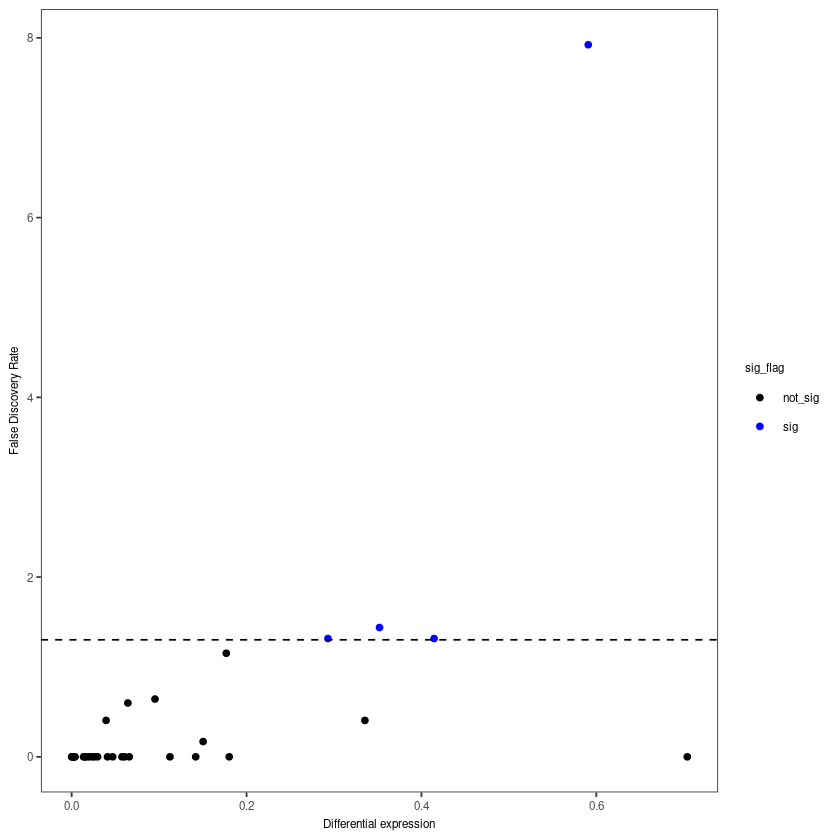

In [16]:
#Plot the plot!
cbind(eqtl.association.pval, eqtl.association.differential.expression, top.snp.df$gene) %>%
data.frame() %>%
rename("pval" = 1, "diff_exp" = 2, "gene" = 3) %>%
mutate(pval = as.numeric(pval)) %>%
mutate(diff_exp = as.numeric(diff_exp)) %>%
mutate("fdr" = p.adjust(pval, method = "BY", n = length(pval))) %>%
mutate("abs_diff_exp" = abs(diff_exp)) %>%
mutate("sig_flag" = ifelse(fdr < 0.05, "sig", "not_sig")) %>%
filter(gene %in% all_of(dqtl.significant.genes)) %>%
filter(!gene %in% "CDKN2B") %>%
ggplot(aes(x = abs_diff_exp, y = -log10(fdr), color = sig_flag)) +
geom_point() +

geom_hline(yintercept = 1.302, linetype = 2) +

scale_color_manual(values = c("black", "blue")) +

theme_bw() +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
) +

theme(
axis.title.x = element_text(color = "black", size = 7),
axis.title.y = element_text(color = "black", size = 7)
) +

theme(
axis.text = element_text(size = 7),
axis.title = element_text(size = 7)
) +

theme(
legend.title = element_text(size = 7),
legend.text = element_text(size = 7)
) +

ylab("False Discovery Rate") +
xlab("Differential expression")

#Export it to the google bucket
setwd('../output')
ggsave("figure_2d.pdf", width = 4, height = 2)

In [17]:
#Calculate the total number of significant variants so that we can annotate the figure with this information
cbind(eqtl.association.pval, eqtl.association.differential.expression, top.snp.df$gene) %>%
data.frame() %>%
rename("pval" = 1, "diff_exp" = 2, "gene" = 3) %>%
mutate(pval = as.numeric(pval)) %>%
mutate(diff_exp = as.numeric(diff_exp)) %>%
mutate("fdr" = p.adjust(pval, method = "BY", n = length(pval))) %>%
mutate("abs_diff_exp" = abs(diff_exp)) %>%
mutate("sig_flag" = ifelse(fdr < 0.05, "sig", "not_sig")) %>%
filter(gene %in% all_of(dqtl.significant.genes)) %>%
arrange(fdr) %>%
head()

,pval,diff_exp,gene,fdr,abs_diff_exp,sig_flag
,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>
1,1.020030e-34,-1.9509119,CDKN2B,1.119386e-32,1.9509119,sig
2,2.173588e-10,-0.5907660,IFNE,1.192654e-08,0.5907660,sig
3,9.955677e-04,0.3520314,DMRTA1,3.641804e-02,0.3520314,sig
4,1.631689e-03,0.2930920,CLSPN,4.830639e-02,0.2930920,sig
5,1.760749e-03,-0.4144608,ELAVL2,4.830639e-02,0.4144608,sig
6,2.888061e-03,-0.1768031,RHD,7.043053e-02,0.1768031,not_sig


In [18]:
#Get the names of the most significant genes
eqtl.summary.df = cbind(eqtl.association.pval, eqtl.association.differential.expression, top.snp.df$gene, top.snp.df$snp) %>%
data.frame() %>%
rename("eqtl_pval" = 1, "eqtl_diff_exp" = 2, "gene" = 3, "snp" = 4) %>%
mutate(eqtl_pval = as.numeric(eqtl_pval)) %>%
mutate(eqtl_diff_exp = as.numeric(eqtl_diff_exp)) %>%
mutate("eqtl_fdr" = p.adjust(eqtl_pval, method = "BY", n = length(eqtl_pval))) %>%
mutate("abs_diff_exp" = abs(eqtl_diff_exp)) %>%
mutate("sig_flag" = ifelse(eqtl_fdr < 0.05, "sig", "not_sig")) %>%
arrange(eqtl_fdr)

setwd('../output')
write.table(eqtl.summary.df, "figure_2d_eqtl_summary_df.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

In [19]:
#Calculate the number of significant and non-significant genes
cbind(eqtl.association.pval, eqtl.association.differential.expression, top.snp.df$gene) %>%
data.frame() %>%
rename("pval" = 1, "diff_exp" = 2, "gene" = 3) %>%
mutate(pval = as.numeric(pval)) %>%
mutate(diff_exp = as.numeric(diff_exp)) %>%
mutate("fdr" = p.adjust(pval, method = "BY", n = length(pval))) %>%
mutate("abs_diff_exp" = abs(diff_exp)) %>%
mutate("sig_flag" = ifelse(fdr < 0.05, "sig", "not_sig")) %>%
group_by(sig_flag) %>%
summarise("num_of_genes" = n())

sig_flag,num_of_genes
<chr>,<int>
not_sig,41
sig,8


In [20]:
#Calculate the median expression for each gene
expression.per.gene = ancestry.only.expression.22q1 %>% 
group_by(variable) %>%
summarise("median_expression" = median(value)) %>%
mutate("unlogged_expression" = 2^median_expression - 1) %>%
rename("gene" = 1)

#Calculate the number of genes with tpm < 5
less.than.5.tpm = expression.per.gene %>%
filter(unlogged_expression < 5) %>%
pull(gene) %>%
unique() %>%
length()

#Total genes in the analysis
total.genes.in.analysis = expression.per.gene %>%
pull(gene) %>%
unique() %>%
length()

print(paste("there are", less.than.5.tpm, "genes with a tpm less than 5 out of a total of", total.genes.in.analysis, "genes"))

[1] "there are 30 genes with a tpm less than 5 out of a total of 49 genes"
